1RSB
===

\begin{align*}
p\left(f\right)  &= \sum_{f_{1},\dots,f_{k}}\delta\left(f;\min_{j=1,\dots,k}\left|f_{j}\right|\prod_{j=1}^{k}\text{sign}\left(f_{j}\right)\right)\prod_{j=1}^{k}q_j\left(f_{j}\right)e^{-y F_{ai}}\\
q(f) &= \sum_{f_1,\dots,f_d} \prod_{b=1,\dots,d} p_b(f_b) \delta\left(f-s-\sum_{b=1,\dots,d}f_b\right)e^{-y F_{ia}}\\
\end{align*}

where
\begin{align*}
F_{ai} &= -2\min_{j=1,\dots,k}|f_{j}|\Theta\left(-\prod_{j=1}^kf_{j}\right)\\
 F_{ia} &=\left|s + \sum_{b=1}^d f_b\right| - \sum_{b=1}^d|f_b|
\end{align*}



In [461]:
using OffsetArrays

const ∏ = prod
const ∑ = sum


function iter_slow_factor(Q, J, y=0.0)
    k = length(Q)
    p = fill(0.0, -J:J)
    for fs in Iterators.product(fill(-J:J,k)...)
        Fai = -2*minimum(abs.(fs))*(∏(fs) < 0)
        w = ∏(q[f1] for (q,f1) ∈ zip(Q,fs)) * exp(-y*Fai)
        f = minimum(abs.(fs))*sign(∏(fs))
        p[clamp(f, -J, J)] += w
    end
    p ./ sum(p)
end

function iter_slow_var(P, s, J, y=0.0) 
    q = fill(0.0, -J:J)
    for fs in Iterators.product(fill(-J:J, length(P))...)
        f = sum(fs) + s
        Fia = abs(f) - sum(abs.(fs)) 
        w = ∏(p[f1] for (p,f1) ∈ zip(P,fs)) * exp(-y*Fia)
        q[clamp(f, -J, J)] += w 
    end
    q ./ sum(q)
end

iter_slow_var (generic function with 3 methods)

Simplifications
--

$F_{ai}$ can be simplified: 

\begin{align}
F_{ai} &= -2\min_{j=1,\dots,k}|f_{j}|\Theta\left(-\prod_{j=1}^kf_{j}\right)\\
&= -2\min_{j=1,\dots,k}|f_{j}|\Theta\left(\textrm{sign}\left(-\prod_{j=1}^kf_{j}\right)\right)\\
&= -2\min_{j=1,\dots,k}|f_{j}|\Theta\left(-\min_{j=1,\dots,k}|f_{j}|\textrm{sign}\left(\prod_{j=1}^kf_{j}\right)\right)\\
&= -2\left|\min_{j=1,\dots,k}|f_{j}|\textrm{sign}\left(-\prod_{j=1}^kf_{j}\right)\right|\Theta\left(-\min_{j=1,\dots,k}|f_{j}|\textrm{sign}\left(\prod_{j=1}^kf_{j}\right)\right)\\
&= 2f\Theta(-f)
\end{align}

So

\begin{align*}
p\left(f\right)= & \sum_{f_{1},\dots,f_{k}}\delta\left(f;\min_{j=1,\dots,k}\left|f_{j}\right|\prod_{j=1}^{k}\text{sign}\left(f_{j}\right)\right)\prod_{j=1}^{k}q_j\left(f_{j}\right)e^{-y 2 f \Theta(-f)}\\
\end{align*}

To compute $p$, define

\begin{align*}
a_k(f) &= p\left(\textrm{sign}\left(\prod_{i=1}^k f_i\right)=\textrm{sign}(f) \wedge |f_1|,\dots,|f_k| \ge |f|\right)\\
\end{align*}

$a_k$ satisfies the recursion

\begin{align*}
a_0(f) &= \delta(\textrm{sign}(f)-1)\\
a_k(f) &= a_{k-1}(f) \sum_{f_k\geq |f|}q_k(f_k) + a_{k-1}(-f) \sum_{f_k \leq -|f|} q_k(f_k)\\
\end{align*}

Then we finally have

$$p_k(f) = \cases{\left\{a_k(f)-a_k(f+\textrm{sign}(f))\right\}e^{-y2f\Theta(-f)} & for $f\neq0$\\
           1-\prod_{j=1}^k(1-q_j(0)) & for $f=0$}$$


In [482]:
function iter_factor(Q, J, y=0)
    a = fill(0.0, -J-1:J+1)
    a[1:J] .= 1
    for q ∈ Q
        Σp, Σm = 0.0, 0.0
        for f=J:-1:1
            ap, am = a[f], a[-f]
            Σp += q[f]; Σm += q[-f]
            #Σp, Σm = ∑(q[f:N]), ∑(q[-N:-f])
            a[+f] = ap*Σp + am*Σm
            a[-f] = am*Σp + ap*Σm
        end
    end
    
    p = fill(0.0, -J:J)
    for f = 1:J
        p[+f] = (a[+f]-a[+f+1])
        p[-f] = (a[-f]-a[-f-1])*exp(2y*f)
    end
    p[0] = 1-∏(1-q[0] for q ∈ Q)
    p ./ sum(p)
end


iter_factor (generic function with 2 methods)

Comparison
--

In [483]:
J=10
y=0.1
Q=[(p=fill(0.0,-J:J); p[-9:9] .= rand(19); p ./=sum(p); p) for i=1:3]
[iter_factor(Q,J,1) iter_slow_factor(Q,J,1)]

21×2 Matrix{Float64}:
 0.0          0.0
 0.681413     0.681413
 0.202063     0.202063
 0.097253     0.097253
 0.0142603    0.0142603
 0.00402553   0.00402553
 0.000826539  0.000826539
 0.000139875  0.000139875
 1.49541e-5   1.49541e-5
 1.52743e-6   1.52743e-6
 9.84515e-7   9.84515e-7
 2.01298e-7   2.01298e-7
 2.76806e-7   2.76806e-7
 3.51482e-7   3.51482e-7
 2.7475e-7    2.7475e-7
 1.75797e-7   1.75797e-7
 8.59071e-8   8.59071e-8
 8.1056e-8    8.1056e-8
 2.05814e-8   2.05814e-8
 1.03743e-8   1.03743e-8
 0.0          0.0

The expression for $F_{ia}$ is

\begin{align*}
    F_{ia} &=\left|s + \sum_{b=1}^d f_b\right| - \sum_{b=1}^d|f_b|
\end{align*}
and

\begin{align*}
q(f) &= \sum_{f_1,\dots,f_d} \prod_{b=1,\dots,d} p_b(f_b) \delta\left(f-s-\sum_{b=1}^df_b\right)e^{-y F_{ia}}\\
&= e^{-y |f|}\sum_{f_1,\dots,f_d} \prod_{b=1,\dots,d} p_b(f_b)e^{y|f_b|} \delta\left(f-s-\sum_{b=1}^df_b\right)\\
\end{align*}


To compute $q_d$, note that

\begin{align}
q(f) &= q_d(f)e^{-y|f|}
\end{align}

where $q_d$ satisfies
\begin{align}
q_0(f) & = \delta(f-s)\\
q_d(f) & = \sum_{f_d} q_{d-1}(f-f_d) p_d(f_d)e^{-y|f_d|} 
\end{align}

In [488]:
function ⊛(p1, p2)
    q = fill(0.0,firstindex(p1)+firstindex(p2):lastindex(p1)+lastindex(p2))
    for f1 in eachindex(p1), f2 in eachindex(p2)
        q[f1+f2] += p1[f1]*p2[f2]
    end
    q
end

function iter_var(P, s, J, y=0)
    q = fill(1.0, s:s)
    for p ∈ P
        q = q ⊛ (p .* exp.(y .* abs.(eachindex(p))))
    end
    q .*= exp.(-y .* abs.(eachindex(q)))
    q2 = fill(0.0, -J:J)
    for f in eachindex(q)
        q2[clamp(f,-J,J)] += q[f]
    end
    q2 ./= sum(q2)
end

iter_var (generic function with 2 methods)

Comparison
--

In [465]:
N=13
y=1.0
s=1
P=[(p=fill(0.0,-J:J); p[-J:J] .= rand(2J+1); p ./=sum(p); p) for i=1:3]
[iter_var(P,s,J,1) iter_slow_var(P,s,J,1)]

21×2 Matrix{Float64}:
 0.000352794  0.000352794
 0.00291488   0.00291488
 0.0166853    0.0166853
 0.0364515    0.0364515
 0.0573177    0.0573177
 0.0875918    0.0875918
 0.100169     0.100169
 0.129575     0.129575
 0.135759     0.135759
 0.158586     0.158586
 0.179919     0.179919
 0.0331314    0.0331314
 0.0117517    0.0117517
 0.00948324   0.00948324
 0.00764835   0.00764835
 0.00719578   0.00719578
 0.00684597   0.00684597
 0.00514038   0.00514038
 0.00436364   0.00436364
 0.00411285   0.00411285
 0.005005     0.005005

In [540]:
using Distributions, ProgressMeter, StatsBase

uni(J) = fill(1/(2J+1), -J:J)
residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

function RSB(Λ, K; 
        maxiter=100, popsize=1000, J=10, 
        popP = fill(1/(2J+1), -J:J, popsize),
        popQ = fill(1/(2J+1), -J:J, popsize), 
        y=0)
    popsize = size(popP, 2)
    Λ1 = residual(Λ)
    K1 = residual(K)

    wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    @showprogress for t = 1:maxiter
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            k = sample(eachindex(K1), wK1)
            Q = [@view popQ[:, j] for j ∈ rand(1:popsize, k)]
            P = [@view popP[:, j] for j ∈ rand(1:popsize, d)]
            s = rand((-1,1))
            popQ[:, i] .= iter_var(P, s, J, y)
            popP[:, i] .= iter_factor(Q, J, y)
        end
    end
    popP, popQ
end

RSB (generic function with 1 method)

In [520]:
Λ = OffsetVector([0,0,0.8,0.2], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
@show R = 1- ∑(d*Λ[d] for d=eachindex(Λ)) / ∑(k*K[k] for k=eachindex(K))
J=10
popsize=10000

R = 1 - ∑((d * Λ[d] for d = eachindex(Λ))) / ∑((k * K[k] for k = eachindex(K))) = 0.2666666666666666


10000

In [521]:
popP, popQ = RSB(Λ,K; J=J, maxiter=500, popsize=popsize, y=0.0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


In [529]:
using StatsBase

centers = argmax.(eachcol(popP))
@show ∑(popP[c,i] for (i,c) in enumerate(centers)) / size(popP, 2)
vals = span(centers)
[vals proportions(centers, vals)]

∑((popP[c, i] for (i, c) = enumerate(centers))) / size(popP, 2) = 0.6568340355494686


7×2 Matrix{Float64}:
 -3.0  0.0012
 -2.0  0.0276
 -1.0  0.2366
  0.0  0.4643
  1.0  0.2389
  2.0  0.0303
  3.0  0.0011

In [507]:
a=rand(10,3); va = @view a[:,[1,2]]

10-element view(::Matrix{Float64}, :, 2) with eltype Float64:
 0.6673198222208538
 0.15963036679075615
 0.31846789801043185
 0.03979827979902595
 0.5734140902174112
 0.20323351984229676
 0.05961124478780544
 0.6952933229568699
 0.8523669613774547
 0.839011405614078

In [509]:
abs.(eachindex(va))

10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [493]:
a=fill(1/(2J+1), -J:J, 10)

21×10 OffsetArray(::Matrix{Float64}, -10:10, 1:10) with eltype Float64 with indices -10:10×1:10:
 0.047619  0.047619  0.047619  0.047619  …  0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619  …  0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619  …  0.047619  0.047619  0.047619
 0.047619  0.047619  0.047619  0.047619     0.047619  0.047619  0.047619
 0.047619  0.047619  0.0476

In [544]:
res = map(0.012:0.002:0.04) do t
    Λ = OffsetVector([0,0,1-t,t], 0:3)
    K = OffsetVector([0,0,0,1], 0:3)
    J=10
    popsize=10000
    α = ∑(d*Λ[d] for d=eachindex(Λ)) / ∑(k*K[k] for k=eachindex(K))
    popP, popQ = RSB(Λ,K; J=J, maxiter=5000, popsize=popsize,  y=0.0);
    centers = argmax.(eachcol(popP))
    deltaw = ∑(popP[c,i] for (i,c) in enumerate(centers)) / size(popP, 2)
    delta2w = ∑(popP[c,i] + max(popP[c-1,i],popP[c+1,i]) for (i,c) in enumerate(centers)) / size(popP, 2)
    @show 1-α  deltaw  delta2w
    1-α, deltaw, delta2w
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:58


1 - α = 0.32933333333333337
deltaw = 1.0
delta2w = 1.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:34


1 - α = 0.3286666666666668
deltaw = 1.0
delta2w = 1.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


1 - α = 0.32799999999999996
deltaw = 1.0
delta2w = 1.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


1 - α = 0.32733333333333337
deltaw = 1.0
delta2w = 1.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:37


1 - α = 0.32666666666666666
deltaw = 0.9999631112459477
delta2w = 0.9999999999992804


Progress: 100%|█████████████████████████████████████████| Time: 0:02:37


1 - α = 0.32600000000000007
deltaw = 0.9712894474569235
delta2w = 0.999940993861664


Progress: 100%|█████████████████████████████████████████| Time: 0:02:44


1 - α = 0.32533333333333336
deltaw = 0.9681679183194659
delta2w = 0.9998960419977299


Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


1 - α = 0.32466666666666677
deltaw = 0.9472608810310218
delta2w = 0.999783964113541


Progress: 100%|█████████████████████████████████████████| Time: 0:02:37


1 - α = 0.32399999999999995
deltaw = 0.9547002550166986
delta2w = 0.9997961669144851


Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


1 - α = 0.32333333333333336
deltaw = 0.9555366008841202
delta2w = 0.9997797996974818


Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


1 - α = 0.32266666666666666
deltaw = 0.9396217298030546
delta2w = 0.9994789628479218


Progress: 100%|█████████████████████████████████████████| Time: 0:02:37


1 - α = 0.32200000000000006
deltaw = 0.9391217492631045
delta2w = 0.9993590813938954


Progress: 100%|█████████████████████████████████████████| Time: 0:02:38


1 - α = 0.32133333333333336
deltaw = 0.9416380653128661
delta2w = 0.9992824144599286


Progress: 100%|█████████████████████████████████████████| Time: 0:03:39


1 - α = 0.32066666666666677
deltaw = 0.9221032149456296
delta2w = 0.9990571132648244


Progress: 100%|█████████████████████████████████████████| Time: 0:04:29


1 - α = 0.31999999999999995
deltaw = 0.9157477265484466
delta2w = 0.9988322848120129


15-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.32933333333333337, 1.0, 1.0)
 (0.3286666666666668, 1.0, 1.0)
 (0.32799999999999996, 1.0, 1.0)
 (0.32733333333333337, 1.0, 1.0)
 (0.32666666666666666, 0.9999631112459477, 0.9999999999992804)
 (0.32600000000000007, 0.9712894474569235, 0.999940993861664)
 (0.32533333333333336, 0.9681679183194659, 0.9998960419977299)
 (0.32466666666666677, 0.9472608810310218, 0.999783964113541)
 (0.32399999999999995, 0.9547002550166986, 0.9997961669144851)
 (0.32333333333333336, 0.9555366008841202, 0.9997797996974818)
 (0.32266666666666666, 0.9396217298030546, 0.9994789628479218)
 (0.32200000000000006, 0.9391217492631045, 0.9993590813938954)
 (0.32133333333333336, 0.9416380653128661, 0.9992824144599286)
 (0.32066666666666677, 0.9221032149456296, 0.9990571132648244)
 (0.31999999999999995, 0.9157477265484466, 0.9988322848120129)

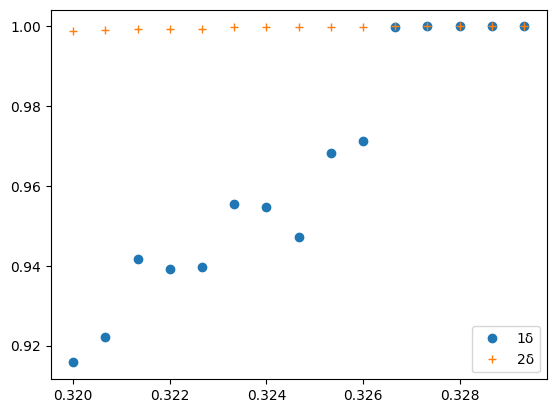

PyObject <matplotlib.legend.Legend object at 0x7f03e54c3cd0>

In [548]:
using Unzip, PyPlot
R,d1,d2 = unzip(res)
plot(R,d1, "o" ,label="1δ")
plot(R,d2, "+", label="2δ")
legend()

1RSB equations for Max-Sum (Survey Propagation) at finite parameter $y$
---
We consider the auxiliary statistical physics model
\begin{align}
    P_y(\{u_{ai},u_{ia}\})=\frac{1}{Z(y)}\mathbb{I}\left(\{u_{ai},u_{ia}\}\text{sat Max-Sum}\right)e^{-yF(\{u_{ai},u_{ia}\})}
\end{align}
in which the variables are the Max-Sum messages living on the edges, and the constraints (that can be put in a factorized form) enforces the Max-Sum equations to be satisfied. Each Max-Sum solution represents a cluster. The Max-Sum solutions are weighted according to their Bethe free energy, which corresponds to the minimal energy (inside the cluster). In the $y\to\infty$ limit one keeps only the clusters with minimal energy

* The distributions $Q_{ia}(u_{ia})$, $Q_{ai}(u_{ai})$ over Max-Sum messages obey the 1RSB equations :
\begin{align}
    Q_{ia}(u_{ia})&=\frac{1}{Z_{ia}}\sum_{\{u_{bi}\}_{b\in\partial i\setminus a}}\delta(u_{ia}-f^{MS}_{ia}(\{u_{bi}\}_{b\in\partial i\setminus a}))e^{-yC_{ia}}\prod_{b\in\partial i\setminus a}Q_{bi}(u_{bi}) \\
    Q_{ai}(u_{ai})&=\frac{1}{Z_{ai}}\sum_{\{u_{ja}\}_{j\in\partial a\setminus i}}\delta(u_{ai}-f^{MS}_{ai}(\{u_{ja}\}_{j\in\partial a\setminus i}))e^{-yC_{ai}}\prod_{j\in\partial a\setminus i}Q_{ja}(u_{ja})    
\end{align}
where $u_{ia}=f^{MS}_{ia}(\{u_{bi}\}_{b\in\partial i\setminus a})$, and $u_{ai}=f^{MS}_{ai}(\{u_{ja}\}_{j\in\partial a\setminus i})$ are shorthand notation for the Max-Sum equations
\begin{align}
    u_{ia}(\sigma_i)&=s_i\sigma_i+ \sum_{b\in\partial i\setminus a}u_{bi}(\sigma_i) - C_{ia}\\
    u_{ai}(\sigma_i)&=\max_{\{\sigma_j\}_{j\in\partial a\setminus i}:{\rm sat}}\left(\sum_{j\in\partial a\setminus i}u_{ja}(\sigma_j)\right) - C_{ai}
\end{align}
and $C_{ia}$, $C_{ai}$ are the constants in the Max-Sum equations
\begin{align}
    C_{ia}&=\max_{\sigma_i}\left(s_i\sigma_i+ \sum_{b\in\partial i\setminus a}u_{bi}(\sigma_i)\right)\\
    C_{ai}&=\max_{\{\sigma_i\}_{i\in\partial a}:{\rm sat}}\left(\sum_{j\in\partial a\setminus i}u_{ja}(\sigma_j)\right)
\end{align}
the constants $Z_{ia}$, $Z_{ai}$ are normalizations of the distributions $Q_{ia}$, $Q_{ai}$ over the Max-Sum messages

* With the parametrization $u_{ai} = f_{ai}\sigma_i+g_{ai}$ we get:
\begin{equation}
    g_{ai} = -\frac{1}{\beta}\log(2{\rm cosh}(\beta f_{ai})\to-|f_{ai}|
\end{equation}
Therefore :
\begin{align*}
    C_{ia}&=\max_{\sigma_i}\left(\sigma_i\left(s_i+ \sum_{b\in\partial i\setminus a}f_{bi}\right)\right) + \sum_{b\in\partial i\setminus a}g_{bi}\\
    &=\left|s_i+ \sum_{b\in\partial i\setminus a}f_{bi}\right| - \sum_{b\in\partial i\setminus a}|f_{bi}|
\end{align*}
and
\begin{align*}
    C_{ai}&=\max_{\{\sigma_i\}_{i\in\partial a}:{\rm sat}}\left(\sum_{j\in\partial a\setminus i}f_{ja}\sigma_j\right)-\sum_{j\in\partial a\setminus i}|f_{ja}|\\
    &= -2\min_{j\in\partial a\setminus i}|f_{ja}|\Theta\left(-\prod_{j\in\partial a\setminus j}f_{ja}\right)
\end{align*}

* We can then write the same 1RSB equations for the distributions $P_{ia}(f_{ia})$, $P_{ai}(f_{ai})$ over the integer parameters $f_{ia}$, $f_{ai}$. We can also write a closed equation on the distribution $P_{ai}$, using that :
\begin{equation}
    P_{ai}(f_{ia})=\frac{1}{Z_{ia}}\sum_{\{f_{bj}\}_{j\in\partial a \setminus i, b\in\partial j\setminus a}}\delta(f_{ia}-F^{MS}(\{f_{bj}\})e^{-y\left(C_{ai}+\sum_{j\in\partial a\setminus i}C_{ja}\right)}\prod_{j\in\partial a \setminus i, b\in\partial j\setminus a}P_{bj}(f_{bj})
\end{equation}
with:
\begin{align*}
    C_{ai}+\sum_{j\in\partial a\setminus i}C_{ja} &= \max_{\sigma:sat}\left(\sum_{j\in\partial a \setminus i}\sigma_j\left(s_j + \sum_{b\in\partial j\setminus a}f_{bj}\right)\right)-\sum_{j\in\partial a\setminus i}\sum_{b\in\partial j\setminus a}|f_{bj}|
\end{align*}

* Random graph ensemble
When the source and the factor graph are random variables the 1RSB messages $P_{ai}$, $(a,i)\in E$ become random variables. Let $(a,i)$ be a uniformly chosen edge in a factor graph drawn from the random ensembl, and let $\mathcal{P}$ be the distribution of the message $P_{ai}$ solution of the 1RSB equation written above. The distribution $\mathcal{P}(p)$ obey consistency equation similar to the RS cavity equations:
\begin{align}
    \mathcal{P}(P)=\sum_{k}\tilde{P}_k\sum_{d_1,\dots, d_k}\left(\prod_{i=1}^k\tilde{\Lambda}_{d_i}\right)\int\prod_{i=1}^k\prod_{j=1}^{d_i}{\rm d}\mathcal{P}(P_{ij})\delta(P-F^{1RSB}(\{P_{i,j}\}))
\end{align}
This equation always admits a trivial fixed point $\mathcal{P}(P)=\delta[P-p^{RS}]$, where $p^{RS}$ is the solution of the RS cavity equation.
In the RS phase, this trivial fixed-point is the unique solution, while in the 1RSB phase, the trivial solution becomes unstable and the above equation admits a non-trivial solution.